# Analyzing two pulses

## Intro

orthogonal decomposition for separating out two pulses which may be saturated and shift in time from event to event

## Loading Libraries

In [134]:
from pylab import *
import h5py
from scipy.optimize import curve_fit
#from scipy.stats import binned_statistic_dd
from scipy.stats import binned_statistic_dd
from scipy import optimize
import pickle
from scipy import stats
from scipy.stats.mstats import theilslopes
from scipy.signal import medfilt
from scipy.signal import savgol_filter
import os

## Initializing Data

### Loading Data

In [14]:
#load data
experiment_run_name = "acqTraces_r106.npy"
my_npy_data = load(experiment_run_name)
#my_hdf5_object = h5py.File(my_file,"r")

(70, 8000)

## Visualizing Some Sample Data from the high speed digitizer (hsd)

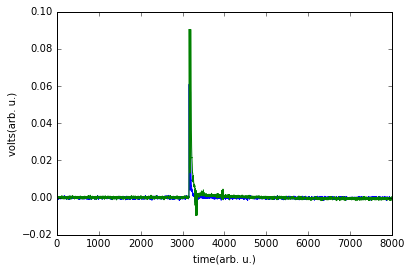

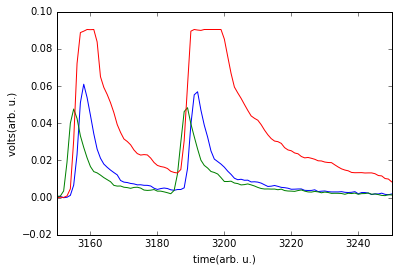

In [504]:
#plot some sample data
#which ones aren't saturated
my_waveform_key = 'hsd/ch1/full_waveform'
ch1_waves = array([i-mean(i[:300]) for i in my_npy_data])# subtracting off offset
plot(ch1_waves[0])
plot(ch1_waves[40])
xlabel("time(arb. u.)")
ylabel("volts(arb. u.)")
show()

plot(ch1_waves[0])
plot(ch1_waves[4])
plot(ch1_waves[40])
xlim(3150,3250)
xlabel("time(arb. u.)")
ylabel("volts(arb. u.)")
show()


#####
#manually identifying non saturated pulses for eigen basis
#####
non_saturated_pulses  = zeros(my_npy_data.shape[0])
non_saturated_pulses[:7]=1
non_saturated_pulses[9:11]=1
non_saturated_pulses = non_saturated_pulses.astype(bool)


#### aligning waveforms

In [506]:
temp = ch1_waves[0]
for i in ch1_waves:
    #shift_amount = 6352-argmax(convolve(ch1_waves[0],i))+100
    shift_amount = 6352-argmax(convolve(diff(ch1_waves[0]),diff(i)))+2000
    temp = vstack([temp,append(zeros(shift_amount),i[:-shift_amount])])

temp =temp[1:]
    

In [508]:
ch1_waves = temp

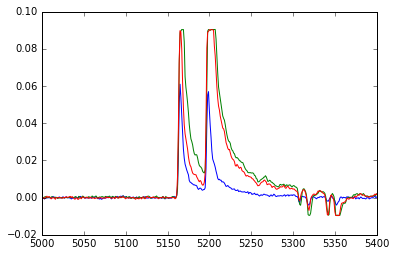

In [512]:
plot(ch1_waves[0])
plot(ch1_waves[40])
plot(ch1_waves[30])
xlim(5000,5400)
show()

### Calculating Eiegen Waveform using SVD on manually selected non-saturated peaks

In [513]:
##############################
##############################
#singular value decomposition on background shots. variable v contains the eigen backgrounds
#u,s,v = svd(ch0_waves) don't use this. it will crash computer unless a small section of the waveforms is chosen
##############################
##############################


#instead manually calculate svd by using the smaller lh sv.
s,u = eig(dot(ch1_waves[non_saturated_pulses],ch1_waves[non_saturated_pulses].transpose()))
v = dot(pinv(u),ch1_waves[non_saturated_pulses])



In [514]:
temp = array([i/dot(i,i)**0.5 for i in v[:25]])#normalizing
v = real(temp)
print(dot(v[0],v[0])) #validating orthogonality
print(dot(v[1],v[1])) #validating orthogonality
print(dot(v[0],v[1])) #validating orthogonality
print(dot(v[0],v[2])) #validating orthogonality
print(dot(v[1],v[2])) #validating orthogonality

1.0
1.0
1.1578195e-15
1.03671411733e-15
6.41847686111e-16


####  dominant eigen waveform

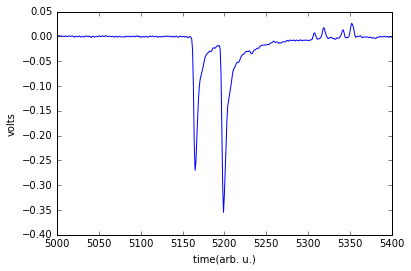

In [516]:
#showing some of the eigen backgrounds
plot(v[0])
#xlim(0,300)
xlabel("time(arb. u.)")
ylabel("volts")
#xlim(3200,3400)
xlim(5000,5400)
show()

####  next dominant eigen waveform

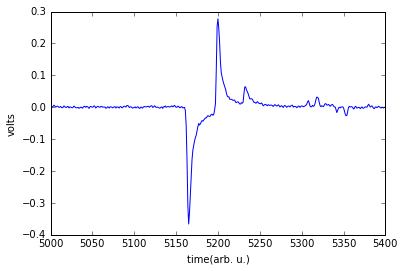

In [518]:
#showing some of the eigen backgrounds
plot(v[1])
xlabel("time(arb. u.)")
ylabel("volts")
#xlim(3200,3400)
xlim(5000,5400)
show()

#### isolating one peak using optimization to get coeficients for eigen basis

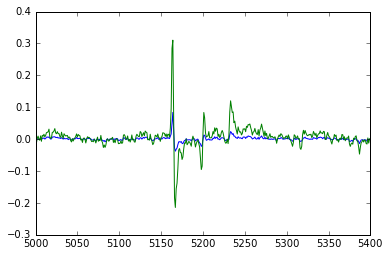

In [523]:
zero_region_start,zero_region_end = 3275,3400
peak_region_start,peak_region_end = 3250,3275
def to_optimize(args):
    initial_guess = args
    #r_squared = -sum((.00*ones(zero_region_end-zero_region_start)- dot(initial_guess,v[:6,zero_region_start:zero_region_end]))**2)
    r_squared = -sum((.00*ones(zero_region_end-zero_region_start)- append(0,diff(dot(initial_guess,v[:6,zero_region_start:zero_region_end]))))**2)
    
    r_squared = r_squared -sum((1.00*ones(peak_region_end-peak_region_start)- dot(initial_guess,v[:6,peak_region_start:peak_region_end]))**2)
    
    r_squared = r_squared+dot(initial_guess,initial_guess)
    
    return r_squared

x0 = array([1,1,1,1,1,1])
res = optimize.minimize(to_optimize, x0, method='Nelder-Mead', tol=1e-6)

plot(-dot(v[:6].transpose(),res.x))
#xlim(3200,3400)

zero_region_start,zero_region_end = 3240,3275
peak_region_start,peak_region_end = 3275,3400
def to_optimize(args):
    initial_guess = args
    #r_squared = -sum((.00*ones(zero_region_end-zero_region_start)- dot(initial_guess,v[:6,zero_region_start:zero_region_end]))**2)
    r_squared = -sum((.00*ones(zero_region_end-zero_region_start)- append(0,diff(dot(initial_guess,v[:6,zero_region_start:zero_region_end]))))**2)
    
    r_squared = r_squared -sum((1.00*ones(peak_region_end-peak_region_start)- dot(initial_guess,v[:6,peak_region_start:peak_region_end]))**2)
    
    r_squared = r_squared+dot(initial_guess,initial_guess)
    
    return r_squared

x0 = array([1,1,1,1,1,1])
res = optimize.minimize(to_optimize, x0, method='Nelder-Mead', tol=1e-6)

plot(-dot(v[:6].transpose(),res.x))
#xlim(5000,5400)
xlim(5000,5400)

show()

### calculating projections of data onto eigen basis (the domintant weight is proporational to the amplitude)

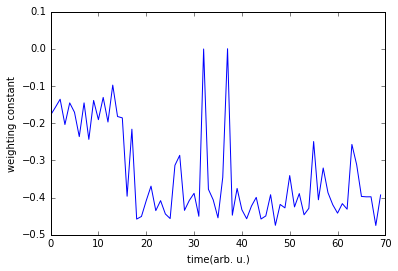

In [537]:
#start,end = (2000,2400)  #which section of waveform to use for svd.  use to select out saturation region
my_mask = zeros(my_npy_data.shape[1])
my_mask[3250:3150]=1.0
my_mask[3220:3300]=1.0
my_mask[3165:3185]=1.0
my_mask[:]=1.0
my_mask = my_mask.astype(bool)

#calculating and showing the weights. x-axis is event number
my_weights = real(dot(ch1_waves[:,my_mask],v[:25,my_mask].transpose()))
my_weights.shape
plot(my_weights[:,0])#the weight of each event
xlabel("time(arb. u.)")
ylabel("weighting constant")
show()

### contribution from each mode

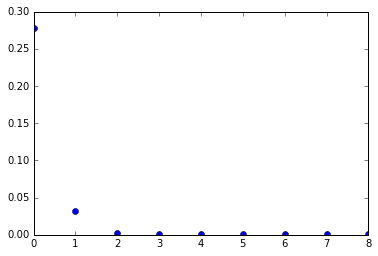

In [538]:
plot(s[:10],'o') #this plot indicates first 4 modes account for 99% of variance
show()

### comparing reconstructed and original wave form

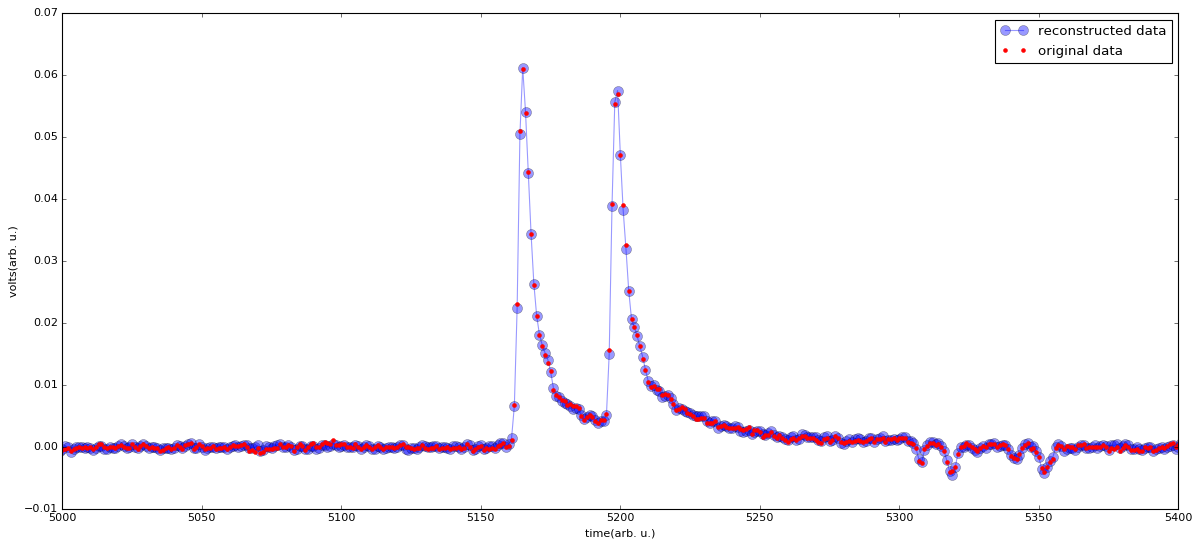

In [539]:
#works on non saturated
event_to_reconstruct=0
reconstructed = sum(my_weights[event_to_reconstruct][i]*v[i] for i in arange(6)) #0th waveform calculated from first 5 eigen waveforms
fig=plt.figure(figsize=(18, 8), dpi= 80, facecolor='w', edgecolor='k')
plot(reconstructed,'-o',alpha=0.4,markersize=9)        #reconstructed
plot(ch1_waves[event_to_reconstruct],'r.',markersize=7) #original data set
#xlim(50,200)
xlim(5000,5400)
xlabel("time(arb. u.)")
ylabel("volts(arb. u.)")
legend(['reconstructed data','original data'])
show()

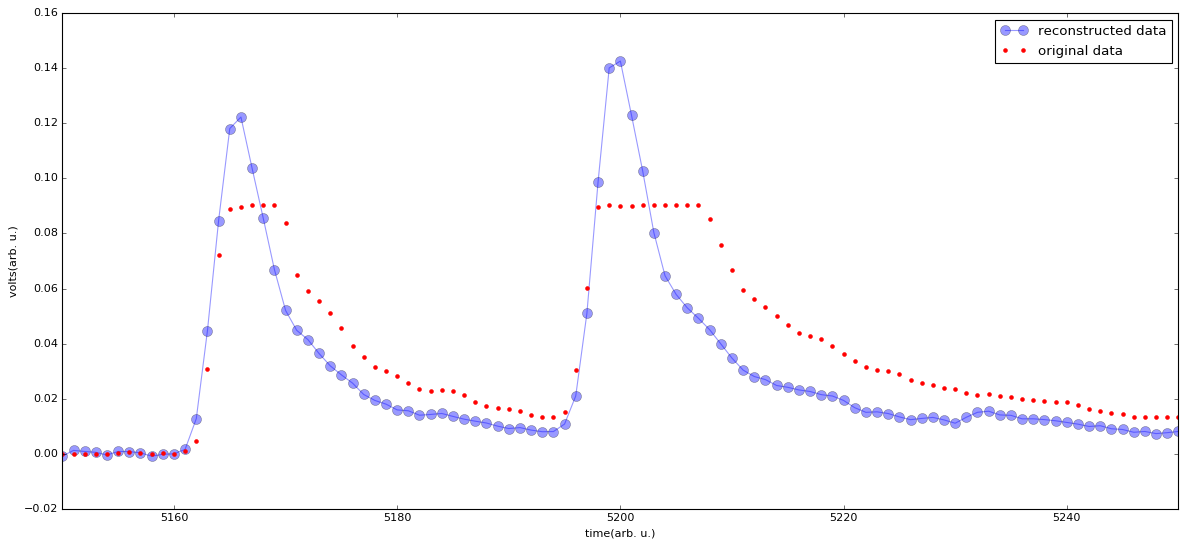

In [540]:
#doesn't work on saturated. needs more finesses
event_to_reconstruct=40
reconstructed = sum(my_weights[event_to_reconstruct][i]*v[i] for i in arange(6)) #0th waveform calculated from first 5 eigen waveforms
fig=plt.figure(figsize=(18, 8), dpi= 80, facecolor='w', edgecolor='k')
plot(reconstructed,'-o',alpha=0.4,markersize=9)        #reconstructed
plot(ch1_waves[event_to_reconstruct],'r.',markersize=7) #original data set
#xlim(50,200)
#xlim(3250,3300)
xlim(5150,5250)
xlabel("time(arb. u.)")
ylabel("volts(arb. u.)")
legend(['reconstructed data','original data'])

show()

### redoing reconstruction with finesse

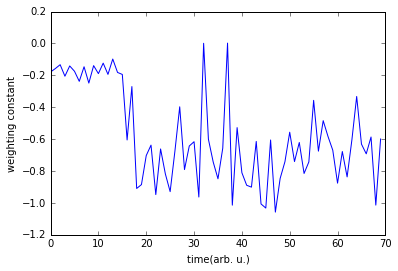

In [545]:
#start,end = (2000,2400)  #which section of waveform to use for svd.  use to select out saturation region
my_mask = zeros(my_npy_data.shape[1])
my_mask[5000:5164]=1.0
my_mask[5170:5195]=1.0
my_mask[5207:5300]=1.0
#my_mask[:]=1.0
my_mask = my_mask.astype(bool)

#calculating and showing the weights. x-axis is event number
#my_weights = real(dot(ch1_waves[:,my_mask],v[:6,my_mask].transpose()))
pseudo_inv = inv(dot(v[:4,my_mask],v[:4,my_mask].transpose()))

my_weights = real(dot(ch1_waves[:,my_mask],v[:4,my_mask].transpose()))
#total 
my_weights = dot(pseudo_inv,my_weights.transpose()).transpose()

plot(my_weights[:,0])#the weight of each event
xlabel("time(arb. u.)")
ylabel("weighting constant")
show()

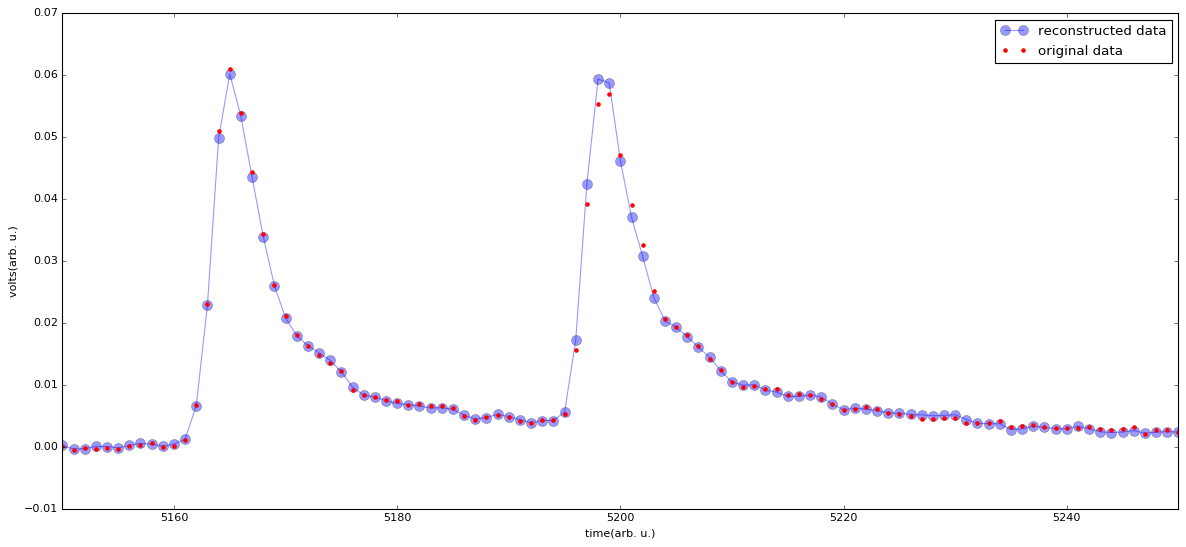

In [546]:
#saturated needs more finesse. doesn't work straight out of the box
event_to_reconstruct=0
reconstructed = sum(my_weights[event_to_reconstruct][i]*v[i] for i in arange(4)) #0th waveform calculated from first 5 eigen waveforms
fig=plt.figure(figsize=(18, 8), dpi= 80, facecolor='w', edgecolor='k')
plot(reconstructed,'-o',alpha=0.4,markersize=9)
plot(ch1_waves[event_to_reconstruct],'r.',markersize=7) #original data set
#xlim(50,200)
xlim(5150,5250)
xlabel("time(arb. u.)")
ylabel("volts(arb. u.)")
legend(['reconstructed data','original data'])
show()

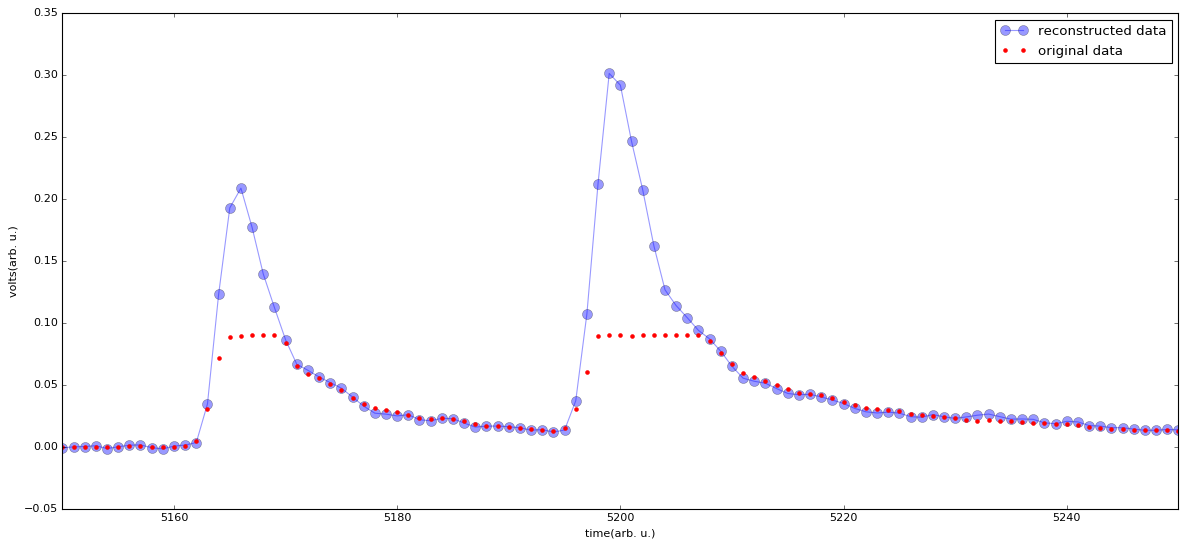

In [547]:
#saturated needs more finesse. doesn't work straight out of the box
event_to_reconstruct=40
reconstructed = sum(my_weights[event_to_reconstruct][i]*v[i] for i in arange(4)) #0th waveform calculated from first 5 eigen waveforms
fig=plt.figure(figsize=(18, 8), dpi= 80, facecolor='w', edgecolor='k')
plot(reconstructed,'-o',alpha=0.4,markersize=9)
plot(ch1_waves[event_to_reconstruct],'r.',markersize=7) #original data set
#xlim(3225,3325)
xlim(5150,5250)
xlabel("time(arb. u.)")
ylabel("volts(arb. u.)")
legend(['reconstructed data','original data'])
show()